# Chương 4: Triển khai mô hình GPT

In [3]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.0
torch version: 2.7.0
tiktoken version: 0.9.0


<img src="https://images.viblo.asia/f208f35e-4ed4-4234-8f53-fb86e34eeb2b.png" width="800px">

## 4.1 Kiến trúc LLM

- Như đã tìm hiểu ở phần trước, các LLMs như GPT chỉ có phần **decoder**
- Đầu vào của mô hình GPT dưới dạng văn bản đã được **tokenized** hóa
- Đầu ra là từ tiếp theo trong câu mà mô hình dự đoán

Chúng ta sẽ tìm hiểu từng phần một trong chiếc hộp **GPT Model**

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="800px">

Chúng ta sẽ tìm hiểu từng phần theo thứ tự đánh số như sau

<img src="https://images.viblo.asia/2e1444b8-d04d-4a83-a5c3-7f56f6d645f5.png" width="800px">

Phần này, sẽ sử làm quen với GPT-2 với một số lý do sau đây:
- **GPT-2** chỉ có 124 triệu tham số => chạy tốt trên các máy tính cá nhân có cấu hình vừa phải
- Các tham số của GPT-2 cũng đã được OpenAI công khai

In [9]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

- `vocab_size`: Số lượng từ vựng là `50257`
- `context_length`: Số lượng token tối đa mà mô hình có thể xử lý trong 1 lần
- `emb_dim`: Số chiều vector **inputs embeddings**
- `n_heads`: Số lượng head trong khi sử dụng cơ chế **multi-head attention**
- `n_layers`: Số lượng **decoder**
- `drop_rate`: Tỷ lệ dropout bao nhiêu %
- `qkv_bias`: Dạng boolean, mang ý nghĩa rằng có sử dụng tham số **bias** trong quá trình tính các ma trận `Q, K, V` hay không ?

Chúng ta tạo bộ khung dự án với 3 class sau đây:

In [6]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Xử lý dữ liệu trong TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Chạy qua lớp chuẩn hóa LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

# TODO
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

# TODO
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    def forward(self, x):
        return x


Hình ảnh mô tả định dạng đầu vào và đầu ra của mô hình GPT-2
- **Token embeđings**: 768 chiều
- Đầu ra từ GPT-2 model cũng 768 chiều

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="800px">

## 4.2 Lớp chuẩn hóa (layer normalization)

- **Layer Normalization** là một kỹ thuật nhằm giảm thiểu sự phân tán của các giá trị trong mô hình, giúp tăng tốc độ hội tụ và cải thiện hiệu suất.
- Ý tưởng chính của **Layer Normalization** là điều chỉnh các giá trị đầu ra sao cho có trung bình bằng 0 và phương sai bằng 1 (được gọi là unit variance).
- Trong GPT-2 và các kiến trúc Transformer hiện đại, Layer Normalization thường được áp dụng trước và sau module Multi-Head Attention.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="800px">

- Ví dụ đơn giản về việc áp dụng chuẩn hóa 

In [11]:
torch.manual_seed(123)

# Tạo ngẫu nhiên 2 dữ liệu huấn luyện với số chiều là 5
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
# Đầu ra sau khi chuẩn hóa
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


Hãy tính giá trị trung bình (mean) và phương sai(variance) cho dữ liệu khi chưa chuẩn hóa

In [12]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- Với cài đặt `dim=-1` sẽ tính theo hàng
- Với `dim=0` thì sẽ tính theo cột

=> Ở đây 2 dữ liệu độc lập nên ta tính theo hàng với `dim=-1`

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="800px">

Tính lại Mean và Variance sau khi chuẩn hóa. Kỳ vọng sẽ là 0 và 1

In [13]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Cài đặt lại `sci_mode=False` để  tắt việc hiển thị các số dưới dạng e mũ

In [14]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


**Công thức chuẩn hóa:**
$y_i = \gamma \cdot \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$
- $y_i$ : Đầu ra sau khi áp dụng Layer Normalization cho mẫu 𝑖
- μ là trung bình
- $σ^2$ là phương sai
- ϵ là một giá trị rất nhỏ để tránh chia cho 0. Trong pytorch, giá trị mặc định của `ϵ` là $10^{-5}$
- γ: Tham số tỷ lệ (scale), điều chỉnh được trong quá trình huấn luyện.
- β: Tham số dịch chuyển (shift), điều chỉnh được trong quá trình huấn luyện.

In [15]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**Biased variance**
- Code ở trên có cài đặt `unbiased=False` nghĩa là tính phương sai theo công thức $\frac{\sum_i (x_i - \bar{x})^2}{n}$ với n là số cột
- So với mặc địch `unbiased=True` sẽ là $\frac{\sum_i (x_i - \bar{x})^2}{n - 1}$

=> Sẽ có 1 sai số nhất định.

Tuy nhiên, đối với các mô hình ngôn ngữ lớn (LLMs), nơi mà số chiều embedding n rất lớn, thì sự khác biệt giữa việc dùng `n` hay `n-1` là rất nhỏ, không đáng kể .

In [16]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [17]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="800px">

## 4.3 Mạng thần kinh truyền thẳng với hàm kích hoạt GELU (Feed forward network with GELU activations)

**Feed Forward Network (FFN)** là một mạng nơ-ron đơn giản giúp mô hình học các đặc trưng phi tuyến tính từ dữ liệu.

> Đặc trưng phi tuyến tính là những mối quan hệ phức tạp trong dữ liệu mà không thể biểu diễn dưới dạng tuyến tính. Chẳng hạn, nghĩa của một từ phụ thuộc vào ngữ cảnh, không chỉ đơn thuần là một phép cộng/trừ vector.

**FNN** có 3 phần bao gồm 2 lớp tuyến tính (Linear) và một hàm kích hoạt (activation function).
- Lớp tuyến tính mở rộng (expansion layer): Biến đổi vector đầu vào từ kích thước `d_model` thành `d_ff` (thường `d_ff = 4 × d_model`)
- Lớp tuyến tính thu hẹp (projection layer): Biến đổi vector từ kích thước `d_ff` trở lại `d_model`
- Hàm kích hoạt (activation function): Đảm nhận nhiệm vụ chính của FNN là học các đặc trưng phi tuyến từ dữ liệu.


![](https://images.viblo.asia/47feff39-f288-4c0e-be75-eda2b15cd4a0.png)

- GELU là một hàm kích hoạt phi tuyến được giới thiệu vào năm 2016 trong bài báo [Gaussian Error Linear Units (GELUs)](https://arxiv.org/pdf/1606.08415) của Dan Hendrycks và Kevin Gimpel
- GELU đã trở thành lựa chọn phổ biến trong các mô hình ngôn ngữ lớn hiện đại như BERT, GPT ...

GELU được định nghĩa bằng công thức: $GELU(x) = x \cdot \Phi(x)$
- x là đầu vào
- $\Phi(x)$ là hàm phân phối tích lũy của phân phối chuẩn (Gaussian CDF)

Tính toán $\Phi(x)$ là một công việc rất tốn kém, cho nên thường dùng công thức xấp xỉ sau:

$\text{GELU}(x) \approx 0.5 x \left( 1 + \tanh\left( \sqrt{\frac{2}{\pi}} \left( x + 0.044715 x^3 \right) \right) \right)$

In [18]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

ReLU (Rectified Linear Unit): Một kiểu hàm kích hoạt khác, đơn giản so với GELU
- Trả về chính giá trị đầu vào nếu đầu vào là số dương; nếu không, nó trả về 0.

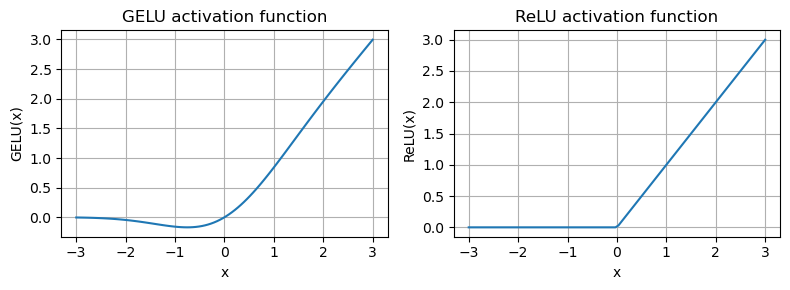

In [19]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

So với **ReLU** thì đồ thị **GELU**:
- Mượt hơn, không gấp khúc đột ngột như ReLU
- Không triệt hết các giá trị âm về 0 như ReLU
=> Giúp cải thiện khả năng học của mạng vì các giá trị âm vẫn có đến kết quả, dẫn đến gradient ổn định hơn.

In [20]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [28]:
print(GPT_CONFIG_124M["emb_dim"])

768


Hình minh họa kích thước của đầu vào/đầu ra khi đi qua các phần của **FNN**

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="800px">

In [21]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## 4.4 Adding shortcut connections

**Shortcut connection** (hay skip connections hoặc residual connections) về cơ bản là một kỹ thuật cho phép "chập" đầu vào với đầu ra. Xem hình minh họa phía dưới sẽ hình dung ra được ngay

Các mô hình ngôn ngữ lớn thường sử dụng nó cho các khối **Multi-head Attention** và **Feed Forward Network**.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="800px">

Với các mô hình có rất nhiều lớp, **Shortcut connections** giúp thông tin từ các lớp trước được truyền tới các ở xa phía sau.

=> Từ đó giúp mô hình duy trì thông tin ngữ cảnh một cách xuyên suốt.

In [22]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        # Ví dụ với 5 layer
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Tính đầu ra của layer hiện tại
            layer_output = layer(x)
            # Nếu use_shorcut=true thì áp dụng
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

#  In ra gradient trung bình của các lớp
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- Khi không sử dụng **shortcut connections**

In [29]:
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


- Khi sử dụng **shortcut connections**

In [30]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


- Từ 2 kết quả in ra ở trên, ta thấy khi sử dụng **shortcut connections** giữ được **Gradient** ở các lớp đầu không bị quá bé (tránh Gradient vanishing)

> Gradient vanishing (sự mất mát gradient) là một hiện tượng trong quá trình huấn luyện mạng neural sâu (deep neural network), khi gradient trở nên cực kỳ nhỏ ở các lớp đầu.

## 4.5 Luồng xử lý của block Transformer

Bây giờ là lúc chúng ta xem luồng hoạt động trong block Transformer khi đã tìm hiểu qua hết các khái niệm như multi-head attention, dropout, feed forward ...

In [7]:
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch03 import MultiHeadAttention

from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    # Thứ tự các bước xử lý
    # 1. Chuẩn hóa 1
    # 2. Multi-head attention
    # 3. Dropout
    # 4. Shortcut connections
    # 5. Chuẩn hóa 2
    # 6. Feed forward
    # 7. Dropout
    # 8. Shortcut connections
    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

<img src="https://images.viblo.asia/f703743b-ed26-4212-aa22-1eb311b60645.png" width="800px">

In [31]:
# Kích thước vector đầu vào và đầu ra là như nhau
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## 4.6 Mô hình GPT

- **GPT** dựa trên kiến trúc Transformer nhưng có bổ sung thêm một số thành phần.
- GPT-2 có 12 khối Transformer.
- **Linear Layer Output** được sử dụng để chuyển đổi đầu ra thành các giá trị thô (**logits**). Từ đó biến đổi tiếp thành dạng vector xác suất cho các từ trong tệp từ vựng (vocabulary).

<img src="https://images.viblo.asia/6b43b332-87f9-4b5d-b128-cb39627f1c5a.png" width="800px">

- Giá trị `cfg["n_layers"] = 12`

In [32]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- Xem thử định dạng đầu vào, đầu ra của GPT

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

# 2 batch, mỗi batch 4 token
batch = torch.tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
# Tính thử số lượng tham số của mô hình
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- Tại sao lại là 163M, chứ không phải 124M ?
- Do mô hình GPT-2 sử dụng chung tham số token embedding layer (`tok_emb`) và output layer (`self.out_head.weight = self.tok_emb.weight`)


In [ ]:
# Tính lại số tham số
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


## 4.7 Sinh văn bản


Từ kết quả vector đầu ra của mô hình GPT như ở phần trên, chúng ta vẫn cần một số bước xử lý nữa để có được dạng văn bản đầu ra. Hãy cùng xem qua cách mô hình sinh ra từ tiếp theo với đầu vào là chuỗi **Hello, I am**.

<img src="https://images.viblo.asia/a93414a1-d7bc-4a04-acd1-786e1a7f7efc.png" width="800px">

- Vector ở hàng cuối cùng từ đầu ra chứa suất về từ tiếp theo cần xuất hiện.
- Chuẩn hóa vector với hàm `Softmax` , ta thu được xác xuất dưới dạng %
- Phần tử có xác suất lớn nhất sẽ là từ tiếp theo
- Chuyển đổi về dạng token ID rồi dạng văn bản, ta thu được từ tiếp theo là **"a"**


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="800px">

Qua mỗi lần lặp, các từ sẽ lần lượt được sinh ra thành 1 câu hoàn chỉnh và có nghĩa

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # Tất nhiên mô hình không thể cứ sinh văn bản vô hạn mà có giới hạn bằng max_new_tokens
    for _ in range(max_new_tokens):

        idx_cond = idx[:, -context_size:]

        # Đầu ra của GPT dạng logits
        with torch.no_grad():
            logits = model(idx_cond)

        # Lấy giá trị vector cuối cùng
        logits = logits[:, -1, :]

        # chạy softmax
        probas = torch.softmax(logits, dim=-1)

        # Tham chiếu giá trị xác suất lớn nhất ra tokenID
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)

        # Tham tokenID vào input để chạy các vòng tiếp theo
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx



<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="800px">

- Chạy thử hàm `generate_text_simple`

In [30]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


- Chuyển đổi đầu ra sang dạng văn bản

In [32]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- Đầu ra của mô hình là một chuỗi khá vô nghĩa là `Hello, I am Featureiman Byeswickattribute argue`, tại sao vậy 🫣 ?
- Lý do rằng mô hình chưa hề được đào tạo, các tham số của mô hình đang được tạo ngẫu nhiên mà thôi.

=> Do đó, chúng ta sẽ còn gặp nhau ở các bài tiếp theo để xem cách một mô hình ngôn ngữ lớn được đào tạo và tinh chỉnh như thế nào, sao cho đầu ra được tự nhiên và mạch lạc hơn.

## Kết

- Xem mã nguồn tại [./gpt.py](./gpt.py)